In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical

from imblearn.over_sampling import RandomOverSampler


In [31]:
df = pd.read_csv("tripadvisor_hotel_reviews.csv")
df = df[['Review', 'Rating']]
df.dropna(inplace=True)

In [30]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [32]:
def label_sentiment(rating):
    if rating >= 4:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

df['sentiment'] = df['Rating'].apply(label_sentiment)


/tmp/ipython-input-1394826828.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


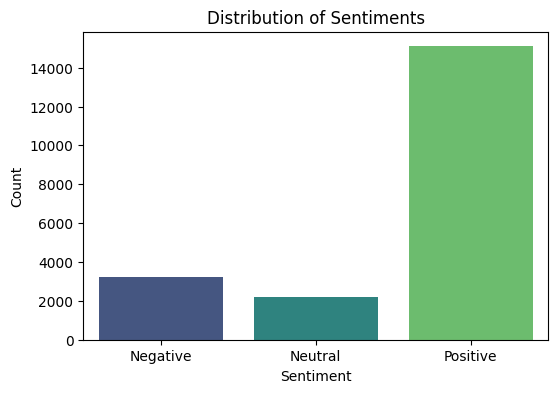

In [44]:
sentiment_counts = df['sentiment'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.show()

In [33]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['cleaned_review'] = df['Review'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_review'])

sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')


In [35]:
X = padded_sequences
y = df['sentiment'].values

# Oversample using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Convert labels to one-hot
y_resampled_cat = to_categorical(y_resampled, num_classes=3)


/tmp/ipython-input-349324166.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resampled_sentiment_counts.index, y=resampled_sentiment_counts.values, palette='viridis')


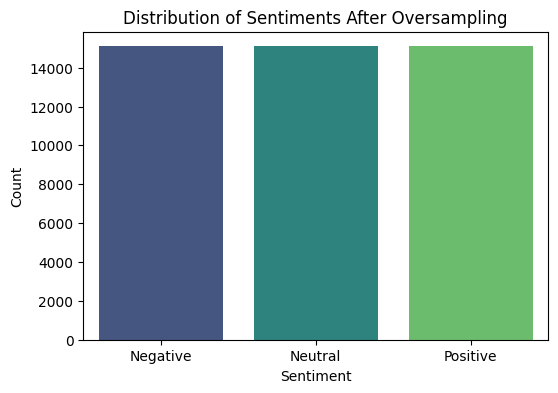

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming y_resampled contains the sentiment labels after oversampling
resampled_sentiment_counts = pd.Series(y_resampled).value_counts().sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=resampled_sentiment_counts.index, y=resampled_sentiment_counts.values, palette='viridis')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments After Oversampling')
plt.show()

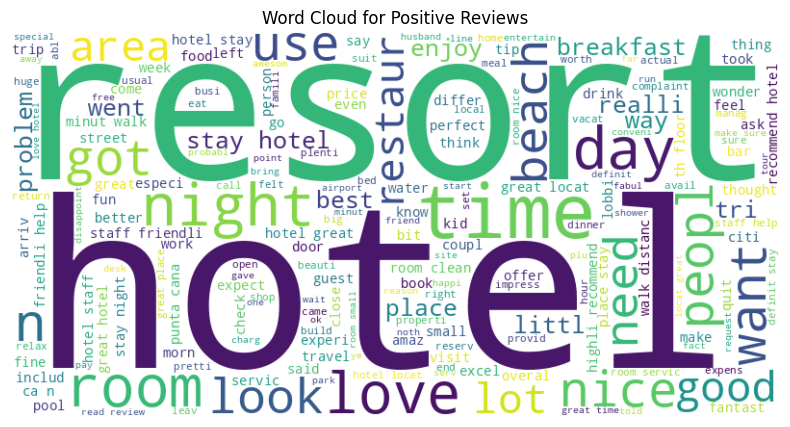

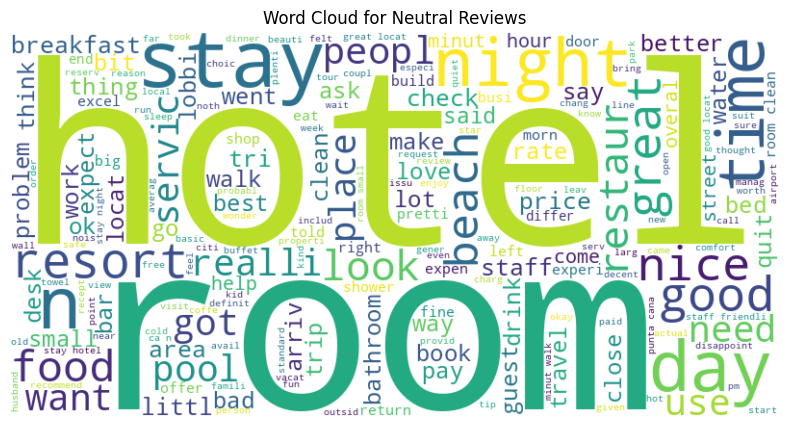

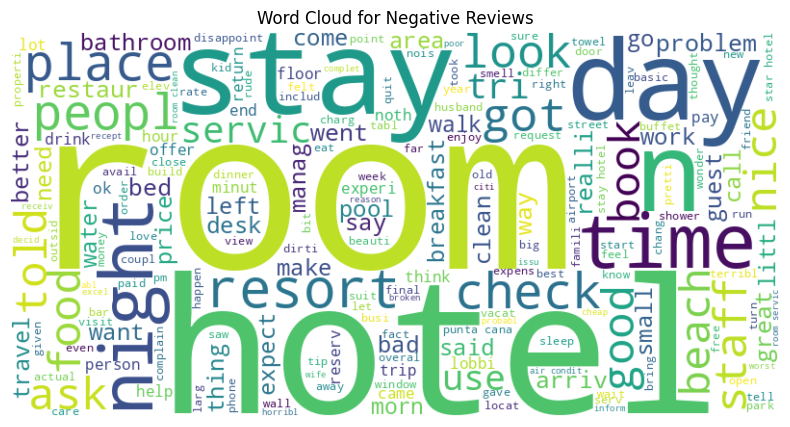

In [48]:
from wordcloud import WordCloud

# Separate reviews by sentiment
positive_reviews = df[df['sentiment'] == 2]['cleaned_review']
neutral_reviews = df[df['sentiment'] == 1]['cleaned_review']
negative_reviews = df[df['sentiment'] == 0]['cleaned_review']

# Generate Word Cloud for Positive Reviews
positive_text = " ".join(review for review in positive_reviews)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Generate Word Cloud for Neutral Reviews
neutral_text = " ".join(review for review in neutral_reviews)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Reviews')
plt.show()

# Generate Word Cloud for Negative Reviews
negative_text = " ".join(review for review in negative_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled_cat, test_size=0.2, random_state=42
)


In [37]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=64, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/8
566/566 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5937 - loss: 0.8302 - val_accuracy: 0.8451 - val_loss: 0.4176
Epoch 2/8
566/566 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8869 - loss: 0.3431 - val_accuracy: 0.9188 - val_loss: 0.2467
Epoch 3/8
566/566 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9433 - loss: 0.1990 - val_accuracy: 0.9360 - val_loss: 0.2049
Epoch 4/8
566/566 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9643 - loss: 0.1269 - val_accuracy: 0.9482 - val_loss: 0.2062
Epoch 5/8
566/566 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9720 - loss: 0.0996 - val_accuracy: 0.9569 - val_loss: 0.1794
Epoch 6/8
566/566 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9807 - loss: 0.0732 - val_accuracy: 0.9553 - val_loss: 0.1572
Epoch 7/8
566/566 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9839 - loss: 0.0599 - val_accuracy: 0.9638 - val_loss: 0.1787
Epoch 8/8
566/566 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9891 - loss: 0.0388 - val_accuracy:

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

    Negative       0.97      0.99      0.98      2992
     Neutral       0.93      0.99      0.96      3001
    Positive       0.98      0.91      0.94      3063

    accuracy                           0.96      9056
   macro avg       0.96      0.96      0.96      9056
weighted avg       0.96      0.96      0.96      9056



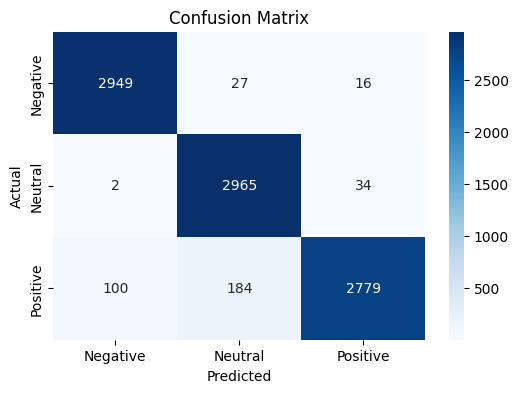

In [39]:
# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 🔁 Reuse the tokenizer, clean_text(), and model from earlier
def predict_sentiment(review):
    cleaned = clean_text(review)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=MAX_LEN, padding='post')
    pred = model.predict(padded)
    label = np.argmax(pred)
    return {0: 'Negative', 1: 'Neutral', 2: 'Positive'}[label]

# ✅ Loop for user input
while True:
    user_input = input("\nEnter a hotel review (or type 'exit' to quit):\n")
    if user_input.lower() == 'exit':
        print("Exiting...")
        break
    sentiment = predict_sentiment(user_input)
    print(f"Predicted Sentiment: {sentiment}")



Enter a hotel review (or type 'exit' to quit):
The stay was amazing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Sentiment: Positive

Enter a hotel review (or type 'exit' to quit):
Mediocre service. It was neither good nor bad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Sentiment: Neutral

Enter a hotel review (or type 'exit' to quit):
No strong feelings about this. It's alright
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Sentiment: Neutral

Enter a hotel review (or type 'exit' to quit):
worst experience ever had
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Sentiment: Negative

Enter a hotel review (or type 'exit' to quit):
highly recommended family friendly
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Sentiment: Positive

Enter a hotel review (or type 'exit' to quit):
unprofessional behaviour by staffs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Sentiment: Negative
